In [3]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
# from datetime import timedelta
# import matplotlib.colors as colors

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### loading data

In [6]:
# mask
meshpath = ['/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/1_mesh_mask.nc']
mask_10 = xr.open_dataset(meshpath[0], chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()
mask_10_base = xr.open_dataset('/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/mesh_mask.nc', chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()

# bathymetry for eddytools
path_bathy = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/'

# observational data
obs_path = '/scratch/usr/shkifmmp/master/data/observations/'

#EKE
path_EXP6 = '/scratch/usr/shkifmmp/manusc/data/EXP06/EKE/'

# DATA DETECTION
datapath= '/scratch/usr/shkifmmp/manusc/data/'

## eddytools

### interpolating

In [10]:
def interpolate(year, model): #model 'EXP06' / 'EXP05'
    YEAR = str(year)
    
    #if model == 'EXP06':
    data_in = sorted(glob('/scratch/usr/shkifmmp/manusc/data/' + model + '/chunked/' +'1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-' + model + '_5d_' + YEAR + '0101_' + YEAR + '1231_grid_[TUV].nc'))
    
    # load data
    data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
               input_ds_chunks = {"time_counter": 73, "t": 73,
                                  "z": 11, "deptht": 11, "depthu": 11, "depthv": 11, "depthw": 11,
                                  "x": 100, "y": 100},
               target_ds_chunks = {"t": 73,
                                   "z_c": 11, "z_l": 11,
                                   "x_c": 100, "x_r": 100, "y_c": 100, "y_r": 100})
    

    # define metrics for xgcm (not strictly necessary)
    at, au = data['e1t'] * data['e2t'], data['e1u'] * data['e2u']
    av, af = data['e1v'] * data['e2v'], data['e1f'] * data['e2f']
    vt, vu, vv, vw = data['e3t'] * at, data['e3u'] * au, data['e3v'] * av, data['e3w'] * at

    data = data.update({'at': at, 'au': au, 'av': av, 'af': af, 'vt': vt, 'vu': vu, 'vv': vv, 'vw': vw})
    data = data.set_coords(['at', 'au', 'av', 'af', 'vt', 'vu', 'vv', 'vw'])

    metrics = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
        ('X', 'Y', 'Z'): ['vt', 'vu', 'vv', 'vw'] # Volumes
    }

    metrics2D = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
    }

    bathy = xr.open_dataset(path_bathy + '1_bathy_meter.nc')
    data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['Bathymetry'].data)})
        
    grid = xgcm.Grid(data, metrics=metrics)

    # Calculate vorticity and Okubo-Weiss parameter and make sure the chunk sizes are as before.
    data_OW = et.okuboweiss.calc(data.isel(z_c=9, z_l=9), grid,
                                 'vozocrtx', 'vomecrty').chunk({'x_c': 1002, 'x_r': 1002,
                                                                'y_c': 629, 'y_r': 629})

    #Merge the new variables `OW` and `vort` to the dataset `data`
    data = xr.merge([data, data_OW], compat='override')

    # INTERPOLATION
    # Define the parameters for the interpolation -- CONSIDER THE DISOCNTINUITY IN THE LONGITUDE
    interpolation_parameters = {'model': 'ORCA',
                                'grid': 'latlon',
                                'start_time': YEAR + '-01-01', # time range start
                                'end_time': YEAR + '-12-31', # time range end
                                'calendar': 'standard', # calendar, must be either 360_day or standard
                                'lon1': 77.5, # minimum longitude of detection region
                                'lon2': 69.5,  # maximum longitude
                                'lat1': -67, # minimum latitude
                                'lat2': -30, # maximum latitude
                                'res': 1./10., # resolution of the fields in degrees
                                'vars_to_interpolate': ['OW', 'vort'], # variables to be interpolated 
                                'mask_to_interpolate': ['fmask', 'tmask','bathymetry']} # masks to interpolate

    # The OW parameter and vorticity just need to be extracted at the depth level at which we want
    # to detect eddies. In this case we chose level 9
    data_int, regridder = et.interp.horizontal(data, metrics, interpolation_parameters, weights=None)


    # Load `OW` into memory so the `.rolling` operation is faster
    OW_tmp = data_int['OW'].compute()

     # Convert all land values to `NaN` so we don't have a lot of zeros when calculating
    # the standard deviation
    OW_tmp = OW_tmp.where(OW_tmp != 0)
    lon_tmp = OW_tmp['lon'].where(OW_tmp['lon'] > 0, other=OW_tmp['lon'] + 360.)
    OW_tmp = OW_tmp.assign_coords({'lon': lon_tmp})

    mean_OW_spatial_std = OW_tmp.rolling(
                          lon=100, center=True, min_periods=1
                          ).std(skipna=True).rolling(
                          lat=100, center=True, min_periods=1
                          ).std(skipna=True).mean('time')


    # Merge all interpolated datasets into on (override is necessary because some mask etc.
    # variables have been written to all datasets)
    data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})
#     data_int = xr.merge([data_int, data_int_OW], 
#                        compat='override')#.chunk({'time': 1, 'lat': 100, 'lon': 100})
    

    # use if OW_std is 2D
#     data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

#     data_int_heat = data_int_heat.chunk({'lon': 3561, 'lat': 501, 'z': 46})
    with ProgressBar():
        data_int.to_netcdf('/scratch/usr/shkifmmp/manusc/data/' + model + '/interpolated/' + 'int_data_77.5_69.5_y' + YEAR + '.nc')
        
    del data, lon_tmp, data_OW, OW_tmp

In [11]:
for y in np.arange(2018,2019):
    interpolate(y, 'EXP05')

Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f
[########################################] | 100% Completed |  7min 40.7s


### load data

In [3]:
#testing first with EXP06
data_int = xr.open_dataset(datapath + 'EXP06/interpolated/int_data_77.5_69.5_y1958.nc')

In [9]:
# ACC mask
mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/interpolated/int_mask_regions.nc').mask_regions

In [5]:
lon1=-90
lon2=30
t=0
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(lon1,lon2)) #
# plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values - 360)

plt.figure(figsize=(26,15))
map1 = plt.pcolormesh(plot_lon, data_test['lat'].values, data_test.sel(lon = slice(lon1,lon2)).OW_acc.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

NameError: name 'data_test' is not defined

<Figure size 1872x1080 with 0 Axes>

In [10]:
def prep_detection(data):
    data = data.where((data.lat < -36) & (data.lat > -65.97), drop=True)
    OW_std_acc = data.OW_std.where(mask_acc).compute()
    OW_acc = data.OW.where(mask_acc).compute()
    vort_acc = data.vort.where(mask_acc).compute()
    data = data.update({'OW_acc': OW_acc,
                        'OW_std_acc': OW_std_acc,
                        'vort_acc': vort_acc})
    return data

### Detection

Things to note for the setting of detection_parameters:

* 'lon1' and 'lon2' need to be in the range (-180, 180). 'lon2' can be smaller than 'lon1' if you want to extract work in a region extending across the dateline (e.g. 'lon1': 160, 'lon2': -170).
*   'OW_thr': data_int if the field OW_std in data_int is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. 'OW_thr': data_int['OW_std'].values if the field OW_std in data_int is 1D.
*  'OW_thr_factor' is usually chosen in the range (-0.5, -0.2) (Chelton et al., 2007; Isern-Fontanet et al., 200320772:IOMEFA2.0.CO;2)).

In [24]:
def detection_sensi(year, model=0, factor=0.2, npix_max=421, npix_min=10, region='drake'):

    """ Function to detect eddies,
        experiment 'EXP05' if model == 0; else (1) 'EXP06', 
        type_d = 0 (applying acc mask) or else (1): whole region
    """
    lat1, lat2 = -65, -37
    if region == 'drake':
        lon1, lon2 = -76, -50
        
    elif region == 'kerg':
        lon1, lon2 = 77.5, 100
    
    folder = 'EXP05' if model == 0 else 'EXP06'
    
#     if 'data_int' in globals():
#         del globals()['data_int']
    
    data_int = xr.open_dataset(datapath + folder + '/interpolated/int_data_77.5_69.5_y' + str(year) + '.nc')
    
#     if (type_d == 0):
    lat1, lat2= -65, -37
    data_int = prep_detection(data_int)
    ow_data = data_int['OW_std_acc'].values
    ow_name = 'OW_std_acc'
        
#     elif (type_d == 1):
#         lat1, lat2= -67, -30
#         ow_data = data_int['OW_std'].values
#         ow_name = 'OW_std'
    
    # Specify parameters for eddy detection
    detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': str(year) + '-01-01', # time range start
                        'end_time': str(year) + '-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': lon1, # minimum longitude of detection region
                        'lon2': lon2, # maximum longitude
                        'lat1': lat1, # minimum latitude
                        'lat2': lat2, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': ow_data,#data_int['OW_std'].values, # 
                        'OW_thr_name': ow_name,#'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -factor, # Okubo-Weiss parameter threshold
                        'Npix_min': npix_min, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': npix_max} # maximum number of pixels (grid cells)

    # We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
    # parameter at this level)
    
#     try: #in case the data_int file corresponds to a different one
#         eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW', 'vort')
#         pass
#     except ValueError:
#         globals()['data_int'] = xr.open_dataset(datapath + folder + '/interpolated/int_data_77.5_69.5_y' + str(year) + '.nc')
    
#     if type_d == 0:
    eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW_acc', 'vort_acc')
#     else:
#         eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW', 'vort')

    
    for i in np.arange(0, len(eddies)):
        datestring = str(eddies[i][0]['time'])[0:10]
        with open('/scratch/usr/shkifmmp/manusc/data/' + folder + '/sensitivity/det_typed0_'
              + str(datestring) + '_eddies_OW' + str(factor) + '_npixmax' + str(npix_max) + '_npixmin' + str(npix_min) + '_reg_' + region +'.pickle', 'wb') as f:
            pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
        f.close()
    return detection_parameters

In [25]:
for i in np.arange(1971,1976):
    detection_sensi(i, model=0, factor=0.2, region = 'kerg')

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step 

In [26]:
for i in np.arange(1971,1976):
    detection_sensi(i, model=0, factor=0.3, region = 'kerg')

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step 

In [27]:
for i in np.arange(1971,1976):
    detection_sensi(i, model=0, factor=0.5, region = 'kerg')

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step 

In [28]:
for i in np.arange(1971,1976):
    detection_sensi(i, model=1, factor=0.2, region = 'kerg')

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step 

In [29]:
for i in np.arange(1971,1976):
    detection_sensi(i, model=1, factor=0.3, region = 'kerg')

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step 

In [30]:
for i in np.arange(1971,1976):
    detection_sensi(i, model=1, factor=0.5, region = 'kerg')

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73
detection at time step  58  of  73
detection at time step  66  of  73
preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step 

In [ ]:
def f_tracking_sensi(type_d, model, year_i, year_e, continuar = False, region = 'drake'):
    """
    type_d = 0 -> ACC REGION / = 1 -> WHOLE REGION
    model = 0 -> EXP05 / = 1 -> EXP06
    
    """
    if model == 1:
        datapath_t = datapath + 'EXP06/detected/'
    elif model == 0:
        datapath_t = datapath + 'EXP05/detected/' #if (type_d == 1) else '/scratch/usr/shkifmmp/master/data/ORION10/eddies_detect/acc/'

    
    if (type_d == 0):
        lat1, lat2= -65, -37
#         if model == 1:
        file_root = 'det_typed0'
        file_spec = 'eddies_OW0.3_npixmax421_npixmin10'
#         elif model == 0:
#             file_root = 'case9'
#             file_spec = 'eddies_OW0.3_77.5_69.5'
        
    else:
        lat1, lat2= -67, -30
        file_root = 'det_typed1'
        file_spec = 'eddies_OW0.2_npixmax1038_npixmin10'
        
        
    # Specify parameters for eddy tracking
    tracking_param = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': str(year_i) + '-01-03', # time range start
                       'end_time': str(year_e) + '-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': 77.5, # minimum longitude of detection region
                       'lon2': 69.5, # maximum longitude
                       'lat1': lat1, # minimum latitude
                       'lat2': lat2, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath_t, # path to the detected eddies pickle files
                       'file_root': file_root,
                       'file_spec': file_spec,
                       'ross_path': datapath_r} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii
    
    if continuar == False:
        tracks_dict, tracks, terminated_list = et.tracking.split_track(tracking_param, in_file=True, continuing=False, tracks=[], terminated_list=[])
        
        
    elif continuar == True:
        
        with open(datapath_t
                  + 'track_19580101_' + str(year_i - 1) + '1231_tracks_typed' + str(type_d)
                  + '.pickle', 'rb') as f:
            tracks = pickle.load(f)
        f.close()
        
        with open(datapath_t
                  + 'terminatedlist_' + str(year_i - 1) + '_tracks_typed' + str(type_d)
                  + '.pickle', 'rb') as f:
            terminated_list = pickle.load(f)
        f.close()
        
        tracks_dict, tracks, terminated_list = et.tracking.split_track(tracking_param, in_file=True, continuing=True, tracks=tracks, terminated_list=terminated_list)

    # We save the tracks for later use
    with open(datapath_t
              + 'track_19580101_' + str(year_e) + '1231_tracks_typed' + str(type_d)
              + '.pickle', 'wb') as f:
        pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    
    with open(datapath_t
              + 'terminatedlist_' + str(year_e) + '_tracks_typed' + str(type_d)
              + '.pickle', 'wb') as f:
        pickle.dump(terminated_list, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    
    with open(datapath_t
              + 'track_dict_19580101_' + str(year_e) + '1231_tracks_typed' + str(type_d)
              + '.pickle', 'wb') as f:
        pickle.dump(tracks_dict, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    
    return tracks_dict, tracks, terminated_list

In [5]:
def detection(year, model=0, factor=0.2, npix_max=421, npix_min=10, type_d = 0):

    """ Function to detect eddies,
        experiment 'EXP05' if model == 0; else (1) 'EXP06', 
        type_d = 0 (applying acc mask) or else (1): whole region
    """
    
    folder = 'EXP05' if model == 0 else 'EXP06'
    
#     if 'data_int' in globals():
#         del globals()['data_int']
    
    data_int = xr.open_dataset(datapath + folder + '/interpolated/int_data_77.5_69.5_y' + str(year) + '.nc')
    
    if (type_d == 0):
        lat1, lat2= -65, -37
        data_int = prep_detection(data_int)
        ow_data = data_int['OW_std_acc'].values
        ow_name = 'OW_std_acc'
        
    elif (type_d == 1):
        lat1, lat2= -67, -30
        ow_data = data_int['OW_std'].values
        ow_name = 'OW_std'
    
    # Specify parameters for eddy detection
    detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': str(year) + '-01-01', # time range start
                        'end_time': str(year) + '-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 69.5, # maximum longitude
                        'lat1': lat1, # minimum latitude
                        'lat2': lat2, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': ow_data,#data_int['OW_std'].values, # 
                        'OW_thr_name': ow_name,#'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -factor, # Okubo-Weiss parameter threshold
                        'Npix_min': npix_min, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': npix_max} # maximum number of pixels (grid cells)

    # We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
    # parameter at this level)
    
#     try: #in case the data_int file corresponds to a different one
#         eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW', 'vort')
#         pass
#     except ValueError:
#         globals()['data_int'] = xr.open_dataset(datapath + folder + '/interpolated/int_data_77.5_69.5_y' + str(year) + '.nc')
    
    if type_d == 0:
        eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW_acc', 'vort_acc')
    else:
        eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, 'OW', 'vort')

    
    for i in np.arange(0, len(eddies)):
        datestring = str(eddies[i][0]['time'])[0:10]
        with open('/scratch/usr/shkifmmp/manusc/data/' + folder + '/detected/det_typed' + str(type_d) + '_'
              + str(datestring) + '_eddies_OW' + str(factor) + '_npixmax' + str(npix_max) + '_npixmin' + str(npix_min) + '.pickle', 'wb') as f:
            pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
        f.close()
    return detection_parameters

In [ ]:
for i in np.arange(2018,2019):
    detection(i, model=0, factor=0.3, npix_max=421, npix_min=10)

preparing data for eddy detection (masking and region extracting etc.)
detection at time step  1  of  73
detection at time step  9  of  73
detection at time step  17  of  73
detection at time step  25  of  73
detection at time step  33  of  73
detection at time step  42  of  73
detection at time step  50  of  73


In [12]:
def open_eddies(model, factor=0.2, npix_max= 250, npix_min = 20): #later update with model

    folder = 'EXP05' if model == 0 else 'EXP06'
    
    files_tmp = sorted(glob('/scratch/usr/shkifmmp/manusc/data/' + folder + '/detected/det_*1958*'
              + '_eddies_OW' + str(factor) + '_npixmax' + str(npix_max) + '_npixmin' + str(npix_min) + '.pickle'))
    
    eddies = {}
    for i in np.arange(0,len(files_tmp)):
        datestring = files_tmp[i][60:70]
        with open('/scratch/usr/shkifmmp/manusc/data/' + folder + '/detected/det_typed0_'
              + str(datestring) + '_eddies_OW' + str(factor) + '_npixmax' + str(npix_max) + '_npixmin' + str(npix_min) + '.pickle', 'rb') as f:
            eddies.update({i: pickle.load(f)})
    return eddies

In [ ]:
# detection_parameters = detection(2001,model=1,npix_max=250)

In [13]:
eddy = open_eddies(0, factor=0.3, npix_max = 421, npix_min = 10)

In [14]:
eddies = eddy

In [15]:
eddies

{}

In [13]:
la = sorted(glob('/scratch/usr/shkifmmp/manusc/data/' + 'EXP05' + '/detected/det_typed1*1958*'
              + '_eddies_OW' + '0.2' + '_npixmax' + '1038' + '_npixmin' + '10' + '.pickle'))

In [6]:
data_int = xr.open_dataset(datapath + 'EXP05' + '/interpolated/int_data_77.5_69.5_y' + '1958' + '.nc')

In [26]:
data_int.sel(lat=slice(-65.97,-36.01))

<xarray.Dataset>
Dimensions:     (time: 73, z: 46, lat: 501, lon: 3561)
Coordinates:
  * time        (time) datetime64[ns] 1958-01-03T12:00:00 ... 1958-12-29T12:0...
  * z           (z) int64 1 2 3 4 5 6 7 8 9 10 ... 37 38 39 40 41 42 43 44 45 46
  * lat         (lat) float32 -65.97 -65.93 -65.89 ... -36.18 -36.09 -36.01
  * lon         (lon) float32 75.5 75.6 75.7 75.8 75.9 ... 71.2 71.3 71.4 71.5
Data variables:
    OW          (time, lat, lon) float64 ...
    vort        (time, lat, lon) float64 ...
    fmask       (z, lat, lon) int8 ...
    tmask       (z, lat, lon) float64 ...
    bathymetry  (lat, lon) float64 ...
    e1f         (lat, lon) float64 ...
    e2f         (lat, lon) float64 ...
    OW_std      (lat, lon) float64 7.284e-11 3.841e-10 ... 3.342e-12 3.338e-12

In [18]:
ow_data = data_int['OW_std'].values
ow_name = 'OW_std'
    

detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1958-01-01', # time range start
                        'end_time': '1958-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 69.5, # maximum longitude
                        'lat1': -30, # minimum latitude
                        'lat2': -67, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': ow_data,#data_int['OW_std'].values, # 
                        'OW_thr_name': ow_name,#'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.2, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 1038} # maximum number of pixels (grid cells)

In [20]:
mask_acc

<xarray.DataArray 'mask_regions' (lat: 501, lon: 3561)>
[1784061 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 -65.97 -65.93 -65.89 -65.85 ... -36.18 -36.09 -36.01
  * lon      (lon) float32 75.5 75.6 75.7 75.8 75.9 ... 71.1 71.2 71.3 71.4 71.5

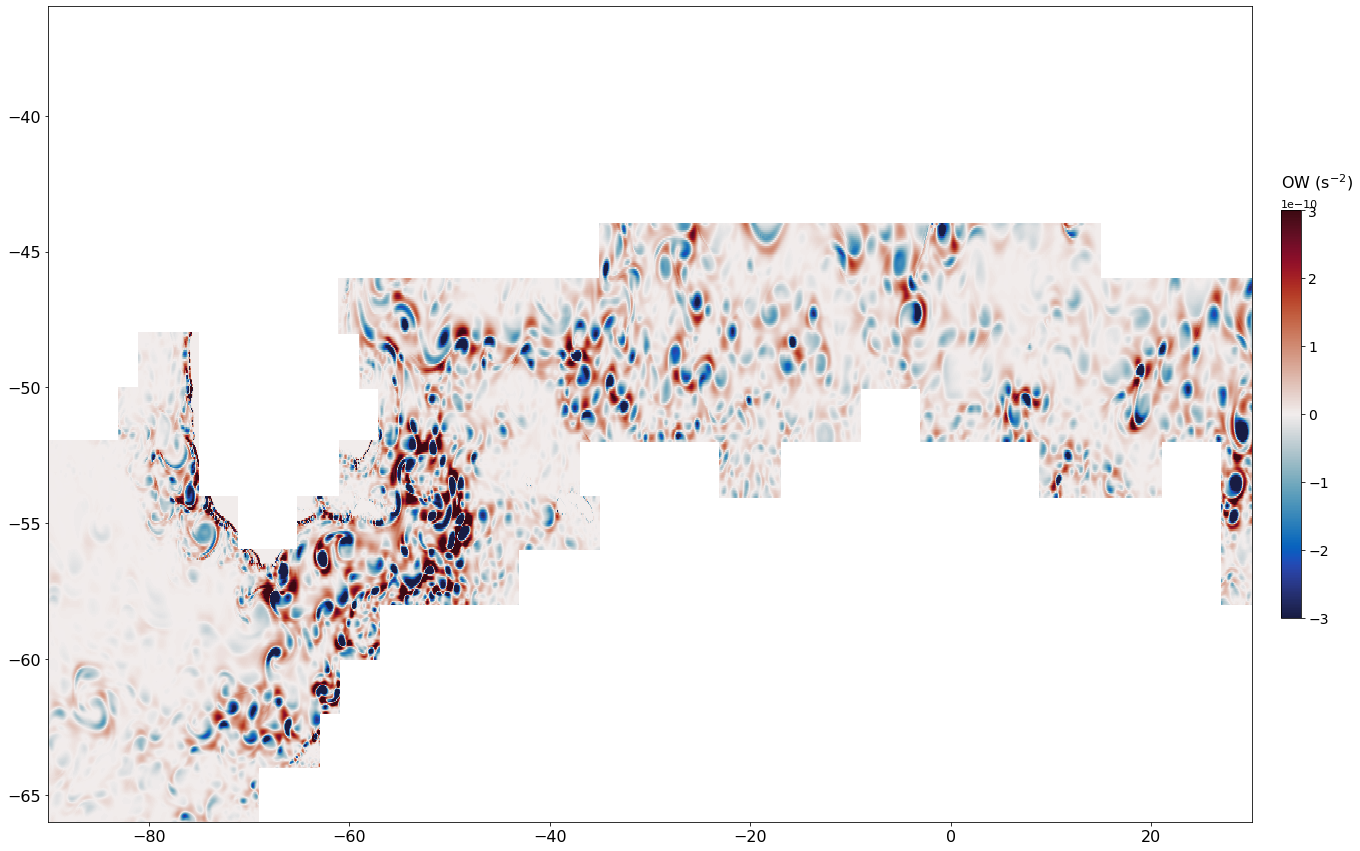

In [29]:
t=40
d_p = detection_parameters
lon1=-90
lon2=30
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(lon1,lon2)) #
# plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values - 360)

plt.figure(figsize=(26,15))
map1 = plt.pcolormesh(plot_lon, data_int.sel(lat=slice(-65.97,-36.01))['lat'].values, 
                      data_int.sel(lat=slice(-65.97,-36.01)).sel(lon = slice(lon1,lon2)).OW.where(mask_acc).isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

# plt.contour(plot_lon, data_int['lat'].values, data_int.mask.sel(lon = slice(-95,17)), colors= 'black')

# for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
#     plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
#              [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
#              color=c, linestyle=l)

# for i in np.arange(0, len(eddies[t])-1):
# #     if eddies[t][i]['lon'] < 0:
#     eddy_lon = eddies[t][i]['lon'] #+ 360
# #     else:
# #         eddy_lon = eddies[t][i]['lon']
#     if eddies[t][i]['type'] == 'cyclonic':
#         for s, c in zip([7, 6], ['k', 'gold']):
#             if (eddies[t][i]['lon'] > lon1) & (eddies[t][i]['lon'] <lon2):
#                 plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
#     elif eddies[t][i]['type'] == 'anticyclonic':
#         for s, c in zip([7, 6], ['k', 'silver']):
#             if (eddies[t][i]['lon'] > lon1) & (eddies[t][i]['lon'] <lon2):
#                 plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
# #         if (eddies[t][i]['lon'] > lon1) & (eddies[t][i]['lon'] <lon2):
#             plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1, pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/test/'
# plt.savefig(save_path + 'detection_EXP06_t{}_npixmax250_npixmin20.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

### checking max diameter in Frenger 2015 // Npix_max

In [ ]:
data_obs_ant = xr.open_dataset(obs_path + 'anticyclones.nc')
data_obs_cyc = xr.open_dataset(obs_path + 'cyclones.nc')

In [20]:
# data_obs_ant.Dia.max().values,data_obs_ant.Dia.quantile(0.95).values ,data_obs_cyc.Dia.max().values, data_obs_cyc.Dia.quantile(0.95).values

(array(293.60019403),
 array(128.64578543),
 array(303.77796863),
 array(128.26431514))

### checking e1t and e2t at 30 degrees

In [14]:
mask = xr.open_dataset(meshpath[0]).squeeze()[['e1t', 'e2t', 'nav_lat']]

In [55]:
# r_e = 6371 * 1e3
# d_max = r_e * np.cos(np.pi * -29.98 / 180) * (np.pi/180) #CALCULATE LONGITUDE DISTANCE AT THIS LATITUDE
# (d_max/10) #in meters

9631.703255476838

In [100]:
data_int.e1f.sel(lat=slice(-60,-59.9) ,lon=22) #getting d_max from model output

<xarray.DataArray 'e1f' (lat: 2)>
array([5560.461287, 5568.869893])
Coordinates:
  * lat      (lat) float32 -60.0 -59.95
    lon      float32 22.0

In [71]:
# (((120*1e3)**2)*np.pi)/(9632.03535**2) # r**2 * pi / (e1f*e2f) # gives the number of pixels

499.8806121320696

In [101]:
# (np.sqrt(((5560.461287 **2) * 20) /np.pi) * 2) /1e3 #reversed calculation, giving pixels and e1f,e2f, gives back the diameter of the eddy that could be found

28.059561421327547